In [27]:
#This is the code we use to generate the residues 
#the poles of F3 function, we can use this in separate .py
#file as well, the reason for creating this notebook is 
#to check the fits as well 

import os 
import numpy as np 
import math 
import matplotlib as mpl 
import matplotlib.pyplot as plt 
from scipy.optimize import curve_fit
import scipy.interpolate
from mpl_toolkits.axes_grid1 import make_axes_locatable

def Ecm_linear_fitting_function(Ecm, m, c):
    result = m*Ecm + c 
    return result 

def Ecm_pole_fitting_function(Ecm, A, Eb):
    result = Ecm/A - Eb/A
    return result 

def residue_fitting_code(Ecm, F3inv, residue_guess, Eb_guess):
    par_guess = [residue_guess, Eb_guess]
    Parameters, Covariance = curve_fit(Ecm_pole_fitting_function, Ecm, F3inv, p0=par_guess)
    FitA = Parameters[0]
    FitEb = Parameters[1]
    SE = np.sqrt(np.diag(Covariance))
    SE_FitA = SE[0]
    SE_Eb = SE[1]
    return FitA, FitEb, SE_FitA, SE_Eb 

In [28]:
def plot_dimension(energy_cutoff):
    Pmom_list = ['000','100','110','111','200']
    ubuntu_drive = '/home/digonto/Codes/Practical_Lattice_v2/3body_quantization/test_files/F3inv_KKpi_pole_testing/'
    number_of_states = []
    for moms in Pmom_list:
        spec_file = ubuntu_drive + 'Kdf0_spectrum_nP_' + moms + '_L20.dat'
        Ltemp, L20_spec = np.genfromtxt(spec_file,unpack=True) 
        spec_list = []
        for i in range(len(L20_spec)):
            if(L20_spec[i]<energy_cutoff):
                spec_list.append(L20_spec[i])
        
        number_of_states.append(len(spec_list)) 

    np_num_state = np.array(number_of_states)
    max_num_state = np_num_state.max() 

    #print(np_num_state)
    #print(max_num_state)
    return max_num_state


In [37]:
def Residue_calculation_and_plotting():
    plt.rcParams.update({'font.size': 18})
    plt.rc('font',**{'family':'serif','serif':['Computer Modern Roman']})
    plt.rc('text', usetex=True)

    energy_cutoff = 0.39
    Pmom_list = ['000','100','110','111','200']
    ubuntu_drive = '/home/digonto/Codes/Practical_Lattice_v2/3body_quantization/test_files/F3inv_KKpi_pole_testing/'
    
    max_num_state = plot_dimension(energy_cutoff)

    plot_y_length = len(Pmom_list)
    plot_x_length = max_num_state
    plot_y_size = len(Pmom_list)*5
    plot_x_size = max_num_state*5
    #print(plot_x_size)
    fig, ax = plt.subplots(plot_y_length,plot_x_length, figsize=(plot_x_size,plot_y_size))
    
    columncounter = 0

    for moms in Pmom_list:
        rowcounter = 0

        filename_str1 =  'calcResidue_F3_nP' + moms + '_L20_state_'
        spec_file = ubuntu_drive + 'Kdf0_spectrum_nP_' + moms + '_L20.dat'
        Ltemp, L20_spec = np.genfromtxt(spec_file,unpack=True) 
        spec_list = []
        for i in range(len(L20_spec)):
            if(L20_spec[i]<energy_cutoff):
                spec_list.append(L20_spec[i])
        
        outputfile = 'residues_P_' + moms +'.dat'
        f = open(outputfile,'w')
        np_spec_list = np.array(spec_list)
        for state in range(0,9,1):
            filename = filename_str1 + str(state) + '.dat'

            if(os.path.exists(filename)):
                (En, Ecm, norm, F3, F3inv, F2, G, K2inv, H) = np.genfromtxt(filename,unpack=True)
                residue_guess = 1.01E-8 
                Eb_guess = np_spec_list[state]

                Fit_residue, Fit_Eb, res_SE, Eb_SE = residue_fitting_code(Ecm, F3inv, residue_guess, Eb_guess)
                #print(filename)
                #print('spec = ',np_spec_list[state])
                #print("res = ", Fit_residue,"+/-",res_SE)
                #print("Eb = ",Fit_Eb,"+/-",Eb_SE)
                #print("----------------------------------")
                f.write(     str(state) + '\t'
                            +str(Eb_guess) + '\t'
                            +str(Fit_Eb) + '\t'
                            +str(Eb_SE) + '\t'
                            +str(Fit_residue) + '\t'
                            +str(res_SE) + '\n' )
                
                titlestring = "$P = [$" + moms + "$]$, state = " + str(state)
                ax[columncounter][rowcounter].set_title(titlestring)
                ax[columncounter][rowcounter].tick_params(axis='both', which='major', labelsize=25)
                ax[columncounter][rowcounter].tick_params(axis='both', which='minor', labelsize=25)
                ax[columncounter][rowcounter].scatter(Ecm,F3inv, marker='o', s=100, linewidth=1, edgecolor='teal',facecolor='white',zorder=2, clip_on=True )
                
                Ecm_list = np.linspace(Ecm.min(),Ecm.max(),1000)
                ax[columncounter][rowcounter].plot(Ecm_list,Ecm_pole_fitting_function(Ecm_list,Fit_residue,Fit_Eb), linewidth=1, color='darkgrey',zorder=3)
                
                ax[columncounter][rowcounter].axhline(y=0,linestyle='--',color='black',zorder=1)
                ax[columncounter][rowcounter].axvline(x=Eb_guess,linestyle='-',color='red',zorder=1)
                ax[columncounter][rowcounter].axvline(x=Fit_Eb,linestyle='-',color='green',zorder=1)
                
                
                fig.tight_layout()
                plt.draw()
                rowcounter = rowcounter + 1
        
        columncounter = columncounter + 1 

        f.close()

        output_plot_file = 'residue_fitting.pdf'
        plt.savefig(output_plot_file)
        #plt.close() 

In [40]:
#This is done after running the previous code, making the plots for 
#the first time and seeing if the data we generated have good fits
#if not, then we make selection of how much data points should be 
#used in fitting, here we have chosen that for state 6 onwards, 
#we would only use 3 data points in the middle, cutting 2 data points
#from first and last 

def Residue_calculation_and_plotting_with_special_case():
    plt.rcParams.update({'font.size': 18})
    plt.rc('font',**{'family':'serif','serif':['Computer Modern Roman']})
    plt.rc('text', usetex=True)

    energy_cutoff = 0.39
    Pmom_list = ['000','100','110','111','200']
    ubuntu_drive = '/home/digonto/Codes/Practical_Lattice_v2/3body_quantization/test_files/F3inv_KKpi_pole_testing/'
    
    max_num_state = plot_dimension(energy_cutoff)

    plot_y_length = len(Pmom_list)
    plot_x_length = max_num_state
    plot_y_size = len(Pmom_list)*5
    plot_x_size = max_num_state*5
    #print(plot_x_size)
    fig, ax = plt.subplots(plot_y_length,plot_x_length, figsize=(plot_x_size,plot_y_size))
    
    columncounter = 0

    for moms in Pmom_list:
        rowcounter = 0

        filename_str1 =  'calcResidue_F3_nP' + moms + '_L20_state_'
        spec_file = ubuntu_drive + 'Kdf0_spectrum_nP_' + moms + '_L20.dat'
        Ltemp, L20_spec = np.genfromtxt(spec_file,unpack=True) 
        spec_list = []
        for i in range(len(L20_spec)):
            if(L20_spec[i]<energy_cutoff):
                spec_list.append(L20_spec[i])
        
        outputfile = 'residues_P_' + moms +'.dat'
        f = open(outputfile,'w')
        np_spec_list = np.array(spec_list)
        for state in range(0,9,1):
            filename = filename_str1 + str(state) + '.dat'

            if(os.path.exists(filename)):
                (En, Ecm, norm, F3, F3inv, F2, G, K2inv, H) = np.genfromtxt(filename,unpack=True)
                residue_guess = 1.01E-8 
                Eb_guess = np_spec_list[state]
                modified_Ecm = []
                modified_F3inv = []
                #here is the special case 
                if(state>=6):
                    for i in range(2,len(Ecm)-2,1):
                        modified_Ecm.append(Ecm[i])
                        modified_F3inv.append(F3inv[i])
                    np_modified_Ecm = np.array(modified_Ecm)
                    np_modified_F3inv = np.array(modified_F3inv)
                    
                    Fit_residue, Fit_Eb, res_SE, Eb_SE = residue_fitting_code(np_modified_Ecm, np_modified_F3inv, residue_guess, Eb_guess)
                else:    
                    Fit_residue, Fit_Eb, res_SE, Eb_SE = residue_fitting_code(Ecm, F3inv, residue_guess, Eb_guess)
                #print(filename)
                #print('spec = ',np_spec_list[state])
                #print("res = ", Fit_residue,"+/-",res_SE)
                #print("Eb = ",Fit_Eb,"+/-",Eb_SE)
                #print("----------------------------------")
                f.write(     str(state) + '\t'
                            +str(Eb_guess) + '\t'
                            +str(Fit_Eb) + '\t'
                            +str(Eb_SE) + '\t'
                            +str(Fit_residue) + '\t'
                            +str(res_SE) + '\n' )
                
                titlestring = "$P = [$" + moms + "$]$, state = " + str(state)
                ax[columncounter][rowcounter].set_title(titlestring)
                ax[columncounter][rowcounter].tick_params(axis='both', which='major', labelsize=25)
                ax[columncounter][rowcounter].tick_params(axis='both', which='minor', labelsize=25)
                ax[columncounter][rowcounter].scatter(Ecm,F3inv, marker='o', s=100, linewidth=1, edgecolor='teal',facecolor='white',zorder=2, clip_on=True )
                
                Ecm_list = np.linspace(Ecm.min(),Ecm.max(),1000)
                ax[columncounter][rowcounter].plot(Ecm_list,Ecm_pole_fitting_function(Ecm_list,Fit_residue,Fit_Eb), linewidth=1, color='darkgrey',zorder=3)
                
                ax[columncounter][rowcounter].axhline(y=0,linestyle='--',color='black',zorder=1)
                ax[columncounter][rowcounter].axvline(x=Eb_guess,linestyle='-',color='red',zorder=1)
                ax[columncounter][rowcounter].axvline(x=Fit_Eb,linestyle='-',color='green',zorder=1)
                
                
                fig.tight_layout()
                plt.draw()
                rowcounter = rowcounter + 1
        
        columncounter = columncounter + 1 

        f.close()

        output_plot_file = 'residue_fitting_modified.pdf'
        plt.savefig(output_plot_file)
        #plt.close() 

In [43]:
#This is done after running the previous code, making the plots for 
#the first time and seeing if the data we generated have good fits
#if not, then we make selection of how much data points should be 
#used in fitting, here we have chosen that for state 6 onwards, 
#we would only use 3 data points in the middle, cutting 2 data points
#from first and last 
#Another thing added is that for P=110 state 2, we chose point 4,5,6 for plotting


def Residue_calculation_and_plotting_with_special_case_2():
    plt.rcParams.update({'font.size': 18})
    plt.rc('font',**{'family':'serif','serif':['Computer Modern Roman']})
    plt.rc('text', usetex=True)

    energy_cutoff = 0.39
    Pmom_list = ['000','100','110','111','200']
    ubuntu_drive = '/home/digonto/Codes/Practical_Lattice_v2/3body_quantization/test_files/F3inv_KKpi_pole_testing/'
    
    max_num_state = plot_dimension(energy_cutoff)

    plot_y_length = len(Pmom_list)
    plot_x_length = max_num_state
    plot_y_size = len(Pmom_list)*5
    plot_x_size = max_num_state*5
    #print(plot_x_size)
    fig, ax = plt.subplots(plot_y_length,plot_x_length, figsize=(plot_x_size,plot_y_size))
    
    columncounter = 0

    for moms in Pmom_list:
        rowcounter = 0

        filename_str1 =  'calcResidue_F3_nP' + moms + '_L20_state_'
        spec_file = ubuntu_drive + 'Kdf0_spectrum_nP_' + moms + '_L20.dat'
        Ltemp, L20_spec = np.genfromtxt(spec_file,unpack=True) 
        spec_list = []
        for i in range(len(L20_spec)):
            if(L20_spec[i]<energy_cutoff):
                spec_list.append(L20_spec[i])
        
        outputfile = 'residues_P_' + moms +'.dat'
        f = open(outputfile,'w')
        np_spec_list = np.array(spec_list)
        for state in range(0,9,1):
            filename = filename_str1 + str(state) + '.dat'

            if(os.path.exists(filename)):
                (En, Ecm, norm, F3, F3inv, F2, G, K2inv, H) = np.genfromtxt(filename,unpack=True)
                residue_guess = 1.01E-8 
                Eb_guess = np_spec_list[state]
                modified_Ecm = []
                modified_F3inv = []
                #here is the special case 
                if(moms=='110' and state==2):
                    for i in range(3,len(Ecm)-1,1):
                        modified_Ecm.append(Ecm[i])
                        modified_F3inv.append(F3inv[i])
                    np_modified_Ecm = np.array(modified_Ecm)
                    np_modified_F3inv = np.array(modified_F3inv)
                    
                    Fit_residue, Fit_Eb, res_SE, Eb_SE = residue_fitting_code(np_modified_Ecm, np_modified_F3inv, residue_guess, Eb_guess)
                
                elif(state>=6):
                    for i in range(2,len(Ecm)-2,1):
                        modified_Ecm.append(Ecm[i])
                        modified_F3inv.append(F3inv[i])
                    np_modified_Ecm = np.array(modified_Ecm)
                    np_modified_F3inv = np.array(modified_F3inv)
                    
                    Fit_residue, Fit_Eb, res_SE, Eb_SE = residue_fitting_code(np_modified_Ecm, np_modified_F3inv, residue_guess, Eb_guess)
                else:    
                    Fit_residue, Fit_Eb, res_SE, Eb_SE = residue_fitting_code(Ecm, F3inv, residue_guess, Eb_guess)
                #print(filename)
                #print('spec = ',np_spec_list[state])
                #print("res = ", Fit_residue,"+/-",res_SE)
                #print("Eb = ",Fit_Eb,"+/-",Eb_SE)
                #print("----------------------------------")
                f.write(     str(state) + '\t'
                            +str(Eb_guess) + '\t'
                            +str(Fit_Eb) + '\t'
                            +str(Eb_SE) + '\t'
                            +str(Fit_residue) + '\t'
                            +str(res_SE) + '\n' )
                
                titlestring = "$P = [$" + moms + "$]$, state = " + str(state)
                ax[columncounter][rowcounter].set_title(titlestring)
                ax[columncounter][rowcounter].tick_params(axis='both', which='major', labelsize=25)
                ax[columncounter][rowcounter].tick_params(axis='both', which='minor', labelsize=25)
                ax[columncounter][rowcounter].scatter(Ecm,F3inv, marker='o', s=100, linewidth=1, edgecolor='teal',facecolor='white',zorder=2, clip_on=True )
                
                Ecm_list = np.linspace(Ecm.min(),Ecm.max(),1000)
                ax[columncounter][rowcounter].plot(Ecm_list,Ecm_pole_fitting_function(Ecm_list,Fit_residue,Fit_Eb), linewidth=1, color='darkgrey',zorder=3)
                
                ax[columncounter][rowcounter].axhline(y=0,linestyle='--',color='black',zorder=1)
                ax[columncounter][rowcounter].axvline(x=Eb_guess,linestyle='-',color='red',zorder=1)
                ax[columncounter][rowcounter].axvline(x=Fit_Eb,linestyle='-',color='green',zorder=1)
                
                
                fig.tight_layout()
                plt.draw()
                rowcounter = rowcounter + 1
        
        columncounter = columncounter + 1 

        f.close()

        output_plot_file = 'residue_fitting_modified_2.pdf'
        plt.savefig(output_plot_file)
        #plt.close() 

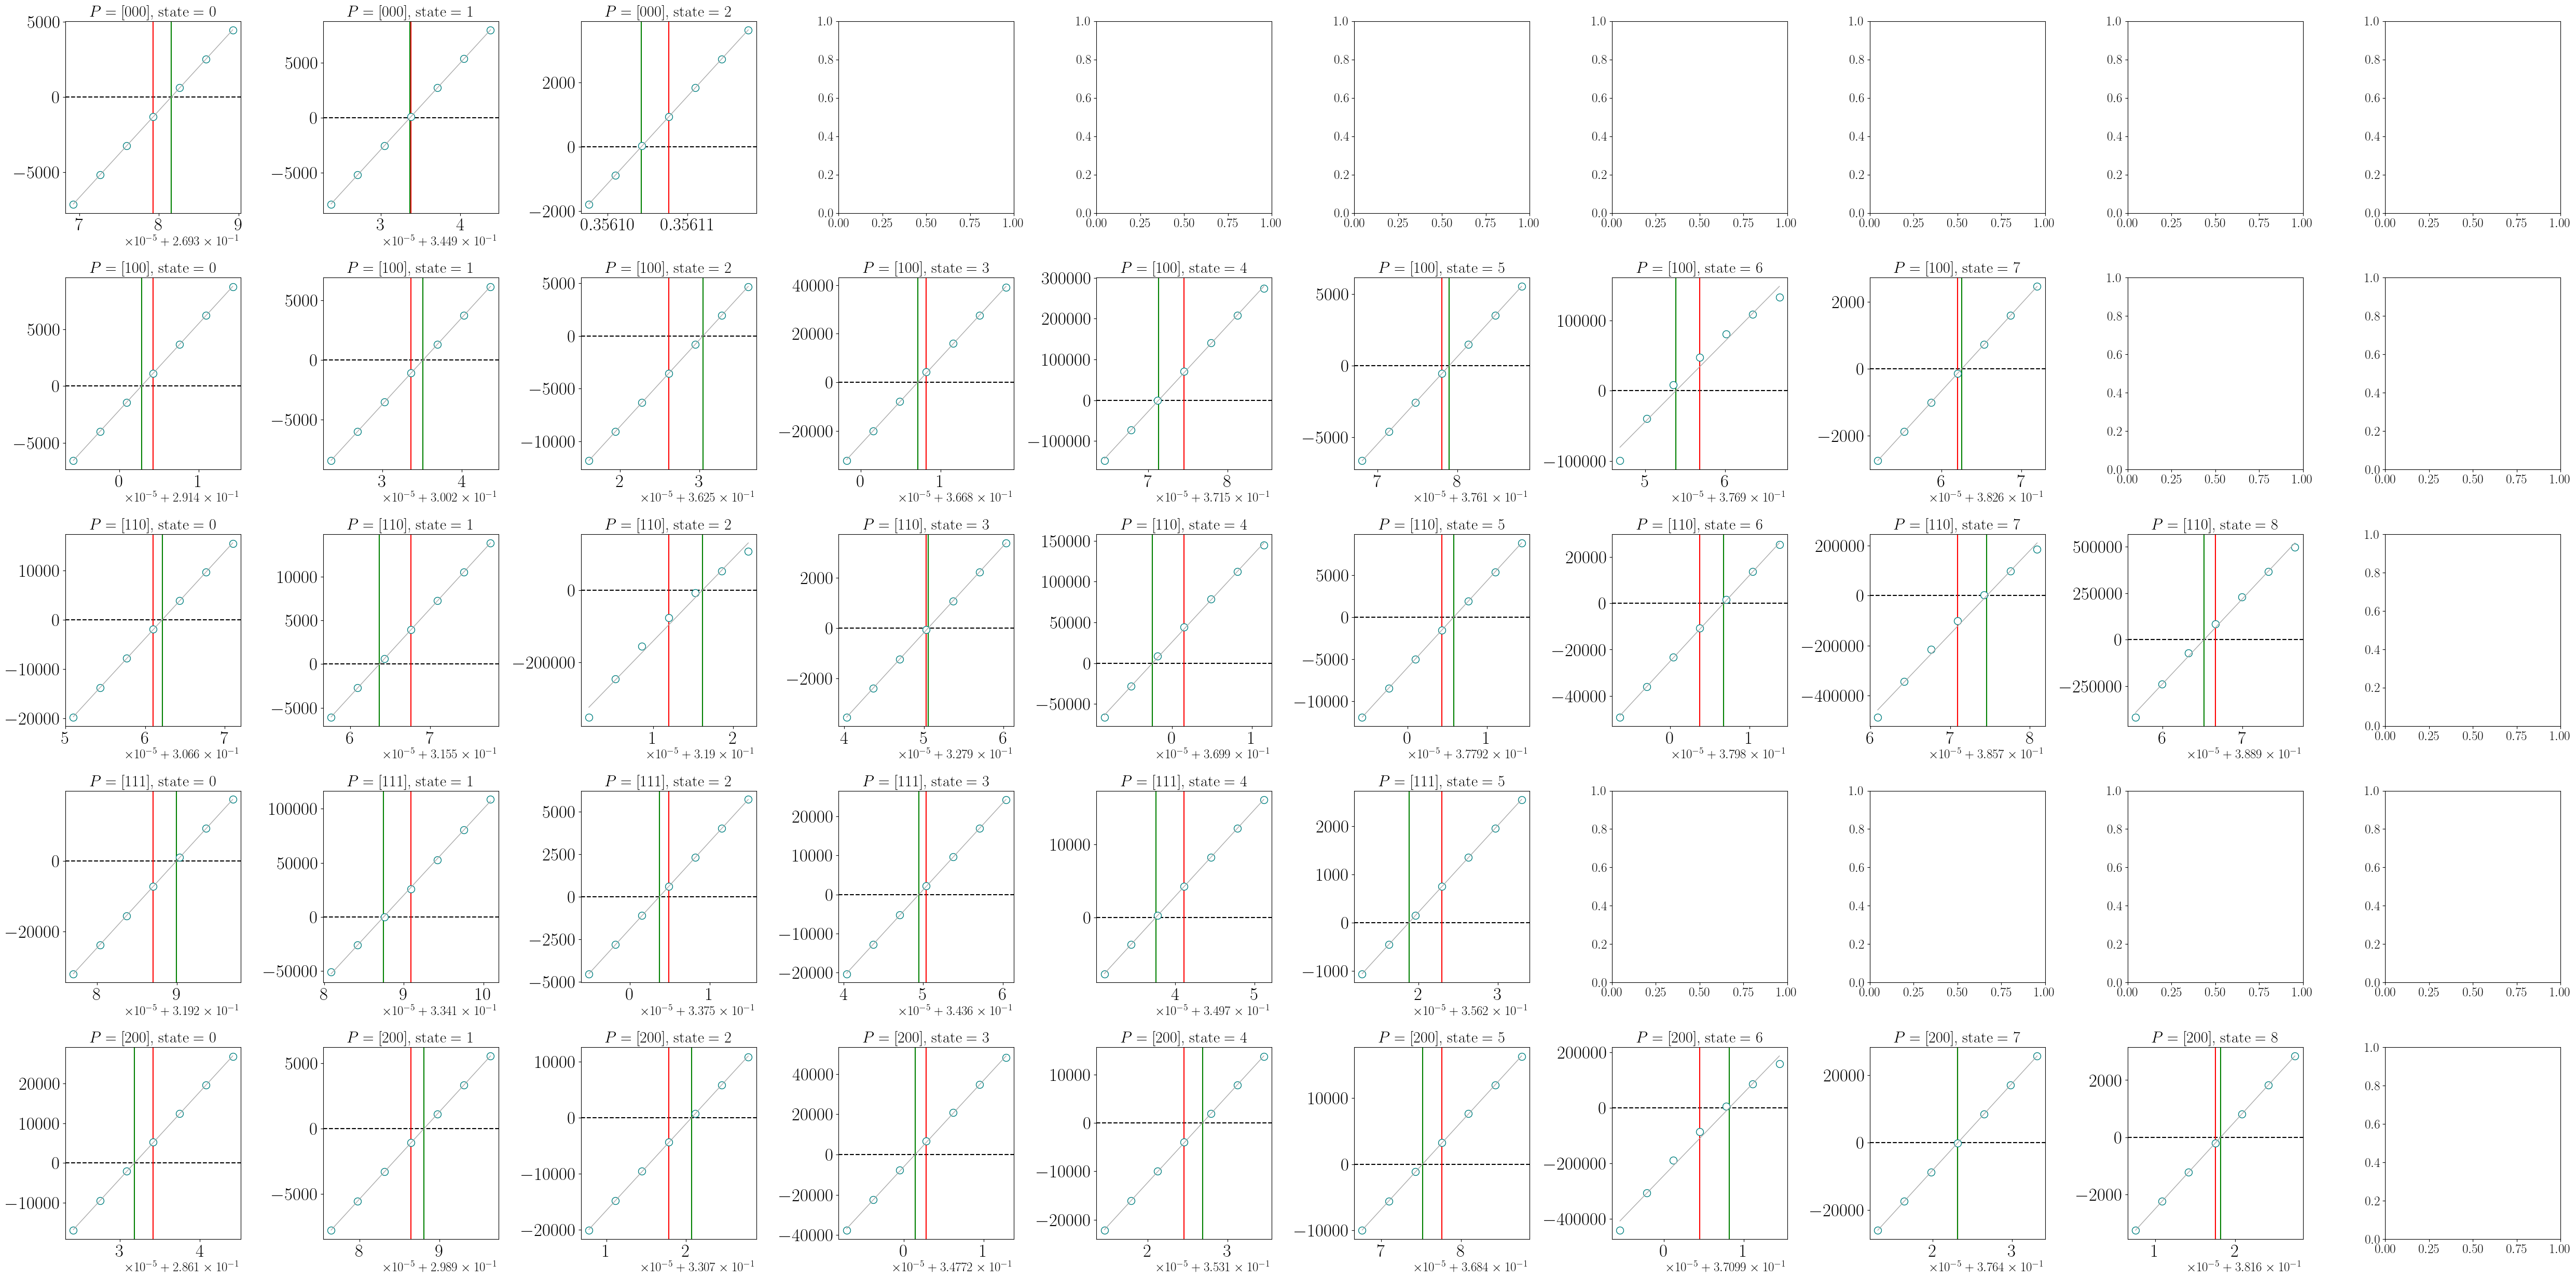

In [38]:
#Run here 
Residue_calculation_and_plotting()
#plot_dimension(0.39)

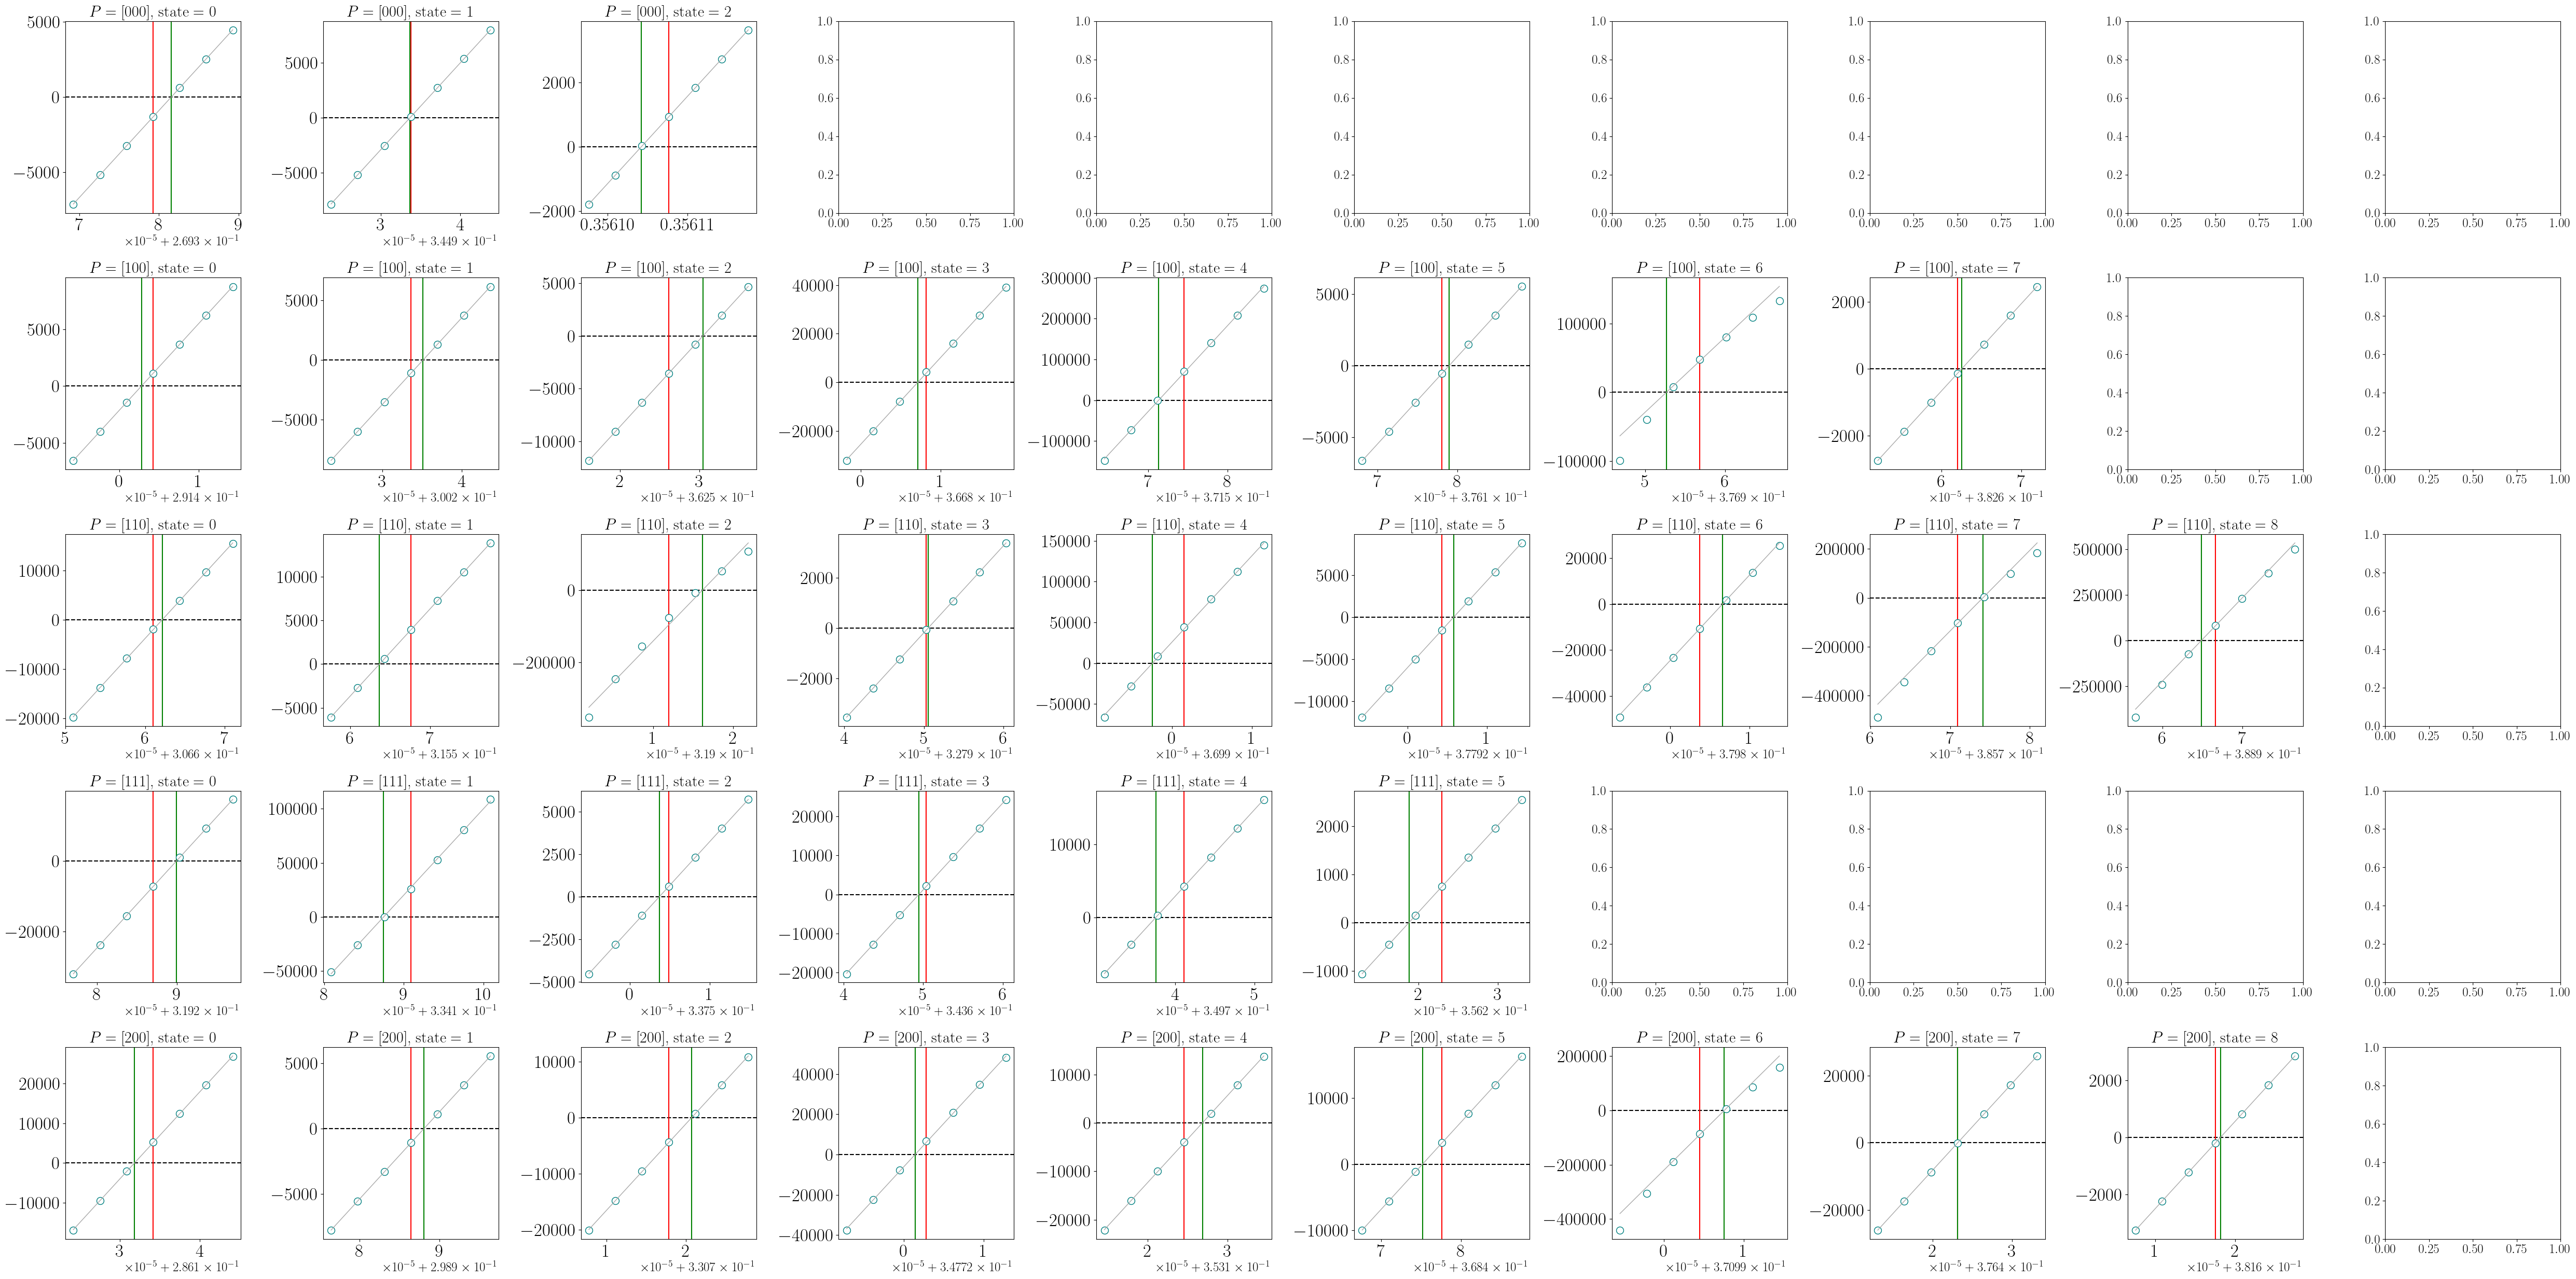

In [41]:
Residue_calculation_and_plotting_with_special_case()

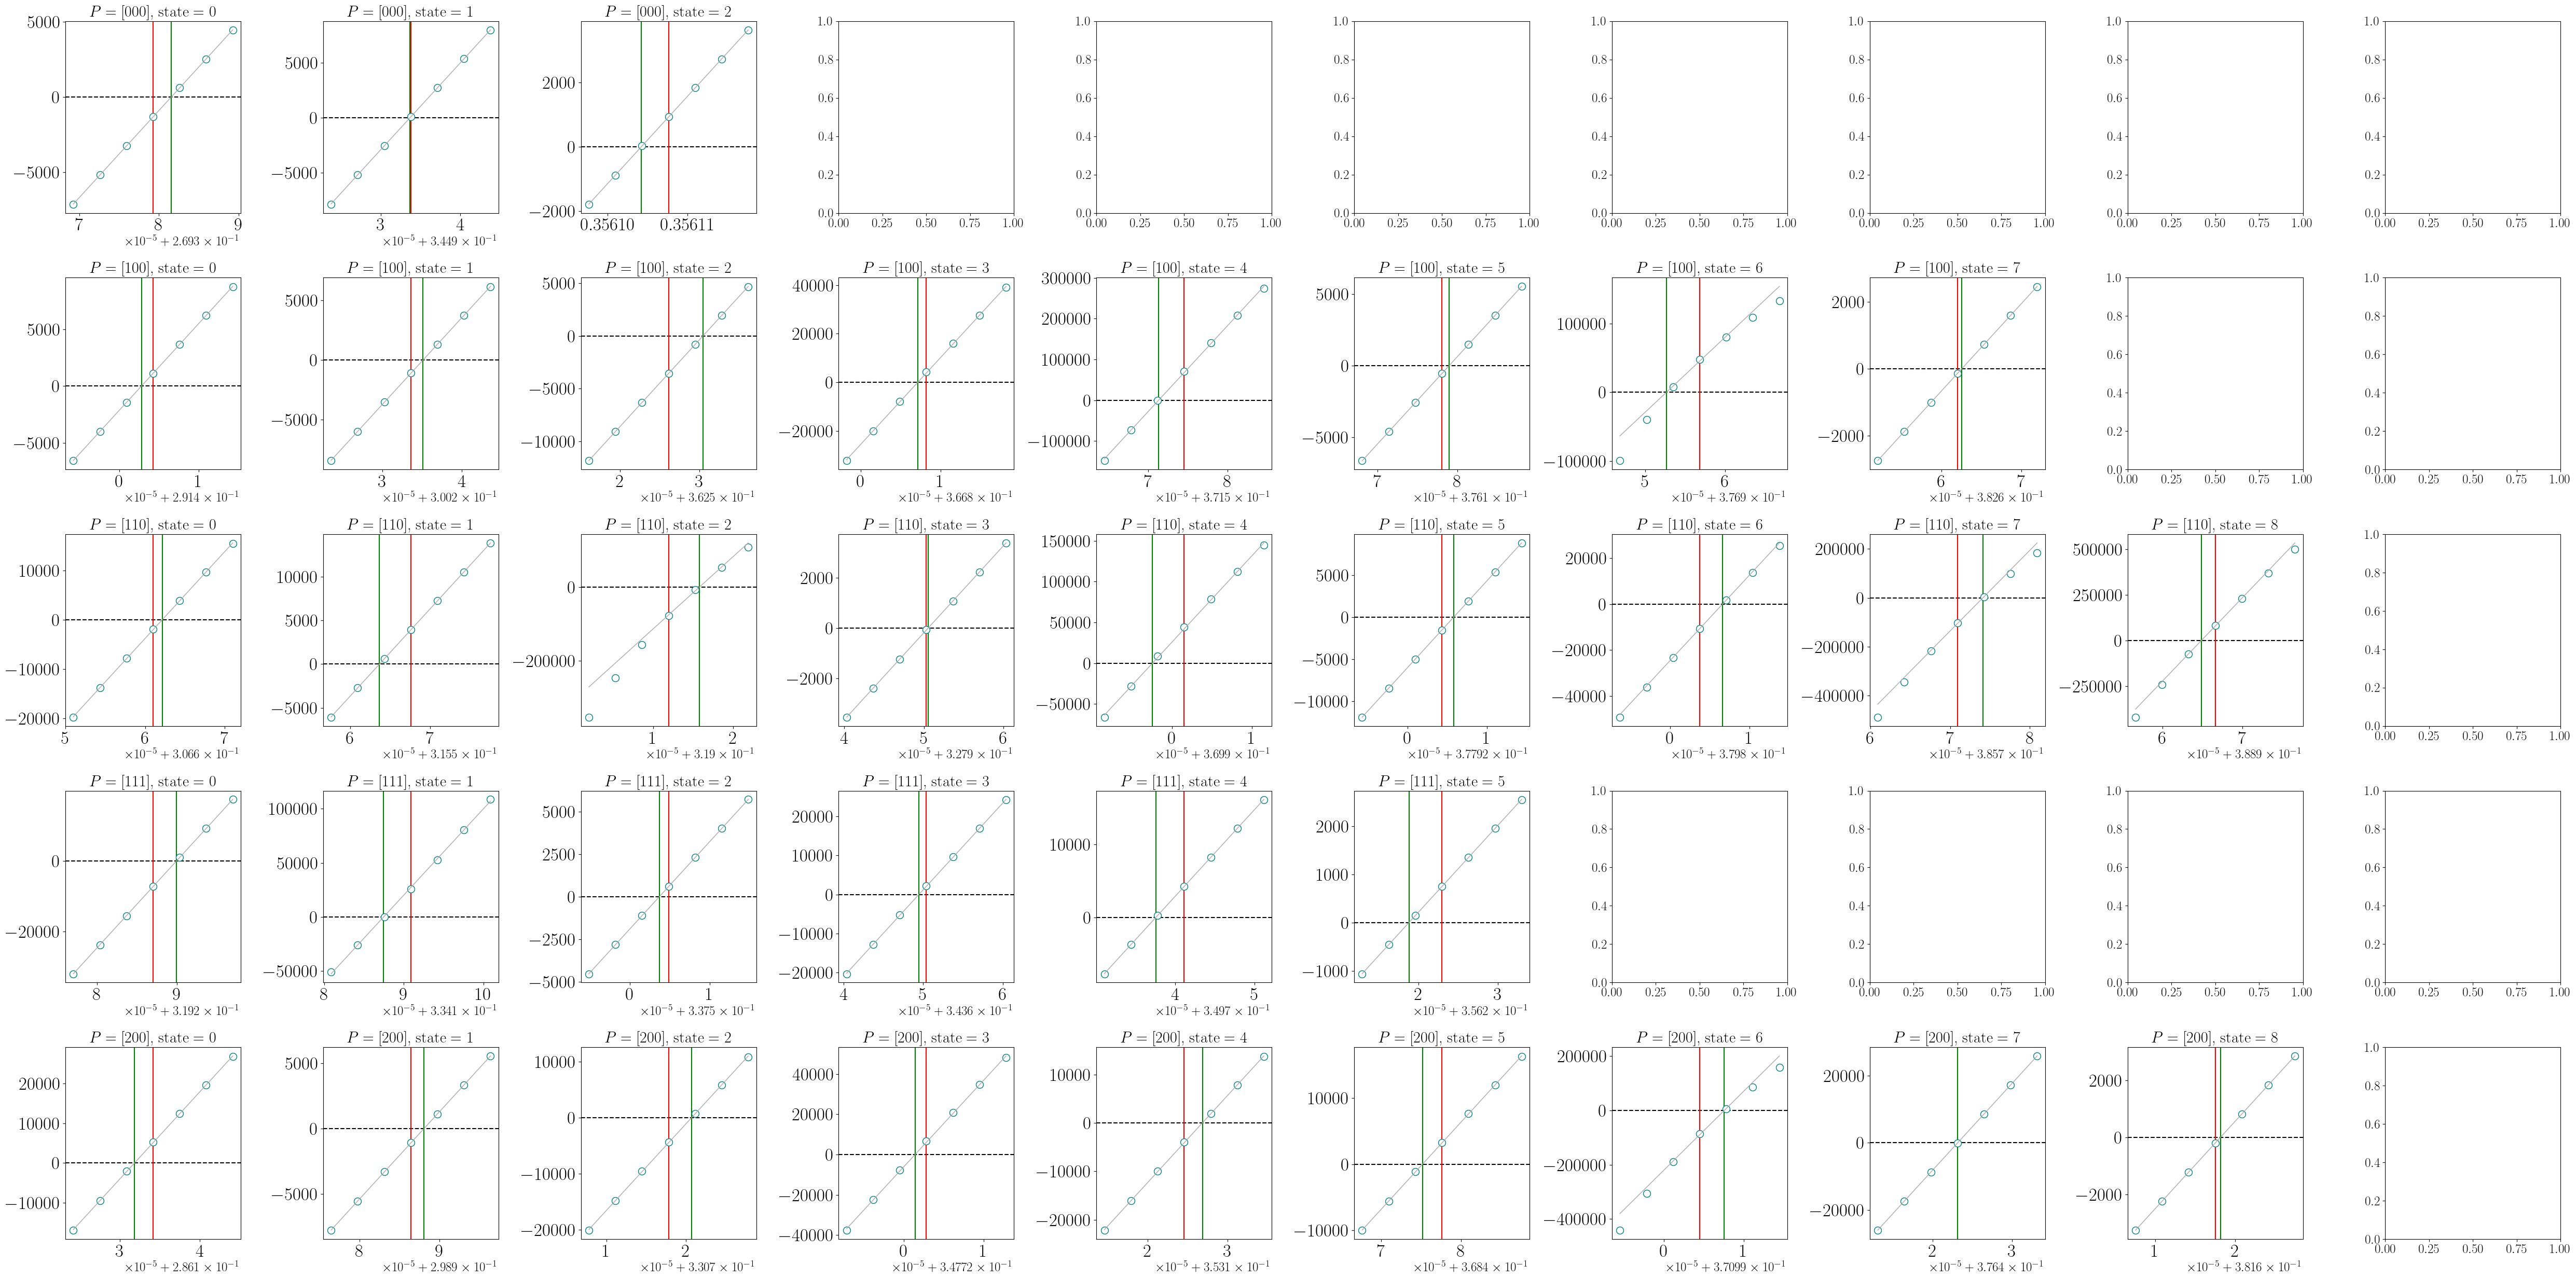

In [44]:
Residue_calculation_and_plotting_with_special_case_2()